<h3>Data Description</h3>
<p>
    The `admissions_processed_morphine_sulfate.csv` file is processed as follows, and is a combination of the `PRESCRIPTIONS.csv`, `ADMISSIONS.csv` and `PATIENTS.csv` files found from the MIMIC-III database,
    <ul>
        <li> There are `6618` unique patients. Each patient could have had multiple hospital stays, but we only considered the first hospital stay that the patient had. The rationale is that we wanted a first impression of the patient.
        <li> These 6618 patients comprise four ethnicities: [WHITE, BLACK, ASIAN, HISPANIC] </li>
        <li> The diagnosis that were selected for consideration were only those that were shared by all four ethnic groups, there is a distribution of these diagnostics among each group in the other jupyter notebook. </li>
        <li> Ages were calculated by taking the difference between birthdate and admittime, for ages that were negative due to HIPAA compliance, we readjusted them to all be 89. </li>
        <li> 122 covariates are considered: [age, HOSPITAL_EXPIRE_FLAG, DIAGNOSIS:%s (114 of them), hosp_duration, INSURANCE (5 types)] </li>
        <li> Only patients that were administered morphine sulfate were then considered, we looked at the total amount they were administered for their single hospital stay duration by taking the FORM_VAL_RX value of the drug.
    </ul>
</p>
<p> Covariates are described above, there are 122 of them, e.g. age and different diagnosis types </p>
<p>Treatment is done by comparing one ethnic group vs the rest, e.g. (WHITE vs [ASIAN, BLACK, HISPANIC]) or (BLACK vs [ASIAN, WHITE, HISPANIC) </p>
<p>Output is the amount of the morphine sulfate the patient is administered</p>


In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import time

In [2]:
df = pd.read_csv("./data/patient_normalized_mme.csv")

In [3]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,age,DRUG,DOSE_MAX_MME
0,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,coronary artery disease\coronary artery bypass...,0,1,71,Oxycodone-Acetaminophen,15.0
1,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,coronary artery disease\coronary artery bypass...,0,1,74,Oxycodone-Acetaminophen,15.0
2,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,bradycardia,0,1,89,TraMADOL (Ultram),2.5
3,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,coronary artery disease\coronary artery bypass...,0,1,69,Oxycodone-Acetaminophen,15.0
4,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,congestive heart failure,0,1,68,Meperidine,5.0


In [4]:
def df_to_X(df):
    
    # include age and hospital expire flag
    covariates = ['age', 'HOSPITAL_EXPIRE_FLAG']
    X = df[covariates]
    
    # include onehots for diagnosis
    diagnosis = pd.get_dummies(df.DIAGNOSIS)
    diagnosis.columns = ['DIAGNOSIS:%s' %d for d in diagnosis.columns]
    X = pd.concat([X, diagnosis], axis=1)
    
    # include duration of hosptial stay
    hosp_duration = (df['DISCHTIME'].astype('datetime64[ns]') - df['ADMITTIME'].astype('datetime64[ns]')).dt.days
    X['hosp_duration'] = hosp_duration
    
    # include onehots for insurance
    insur = pd.get_dummies(df.INSURANCE)
    insur.columns = ['INSURANCE:%s' %i for i in insur.columns]
    X = pd.concat([X, insur], axis=1)  

    
    # normalize duration because it is non-categorical
    d_mu = X['hosp_duration'].mean()
    d_std = X['hosp_duration'].std()
    X['hosp_duration'] = X['hosp_duration'].apply(lambda dp: (dp-d_mu)/d_std)

    # normalize age because non-categorical
    age_mu = X['age'].mean()
    age_std = X['age'].std()
    X['age'] = X['age'].apply(lambda age: (age-age_mu)/age_std)

    return X

def df_to_T(df, eth):
    return df['ETHNICITY'].apply(lambda x: int(x==eth))

def df_to_Y(df):
#     pass # TODO: need to change the column below to new normalized dosage outcome
    return df['DOSE_MAX_MME']

In [6]:
X = df_to_X(df)
T = df_to_T(df, 'WHITE')
Y = df_to_Y(df)
print('X: ', X.shape)
print("T: ", T.shape)
print("Y: ", Y.shape)

X:  (10209, 104)
T:  (10209,)
Y:  (10209,)


### Computing Weighted Means and ATEs

In [8]:
from sklearn.ensemble import GradientBoostingClassifier as GradBoost

In [9]:
# efficiently compute all pairwise ATEs
treatments = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC']

all_means = {}
all_clfs = {}
all_prop_weights = {}

for t in treatments:
    #  using propensity scores to weight patients
    T = df_to_T(df, t)
    clf = GradBoost(n_estimators=500).fit(X, T)

    # compute the propensity-score weighted mean outcome for this treated subpopulation
    treated = (T == 1)
    X_treated = X[treated]
    prop_weights = (len(X_treated) / len(X)) * np.reciprocal(clf.predict_proba(X_treated)[:,1])
    reciprocal = len(X_treated) # np.sum(prop_weights)
    weighted_mean = sum(np.multiply(Y[treated], prop_weights)) / reciprocal
    print('weighted mean for treatment {}: {}'.format(t, weighted_mean))

    all_clfs[t] = clf
    all_prop_weights[t] = prop_weights
    all_means[t] = weighted_mean
    
# compute all pairwise ate's
for i in range(len(treatments)):
    for j in range(i + 1, len(treatments)):
        t1 = treatments[i]
        t2 = treatments[j]
        print('ATE {} - {}: {}'.format(t1, t2, all_means[t1] - all_means[t2]))

weighted mean for treatment WHITE: 222.06501040081585
weighted mean for treatment BLACK: 103.4679145795276
weighted mean for treatment ASIAN: 40.4602287838694
weighted mean for treatment HISPANIC: 45.55542255805838
ATE WHITE - BLACK: 118.59709582128825
ATE WHITE - ASIAN: 181.60478161694647
ATE WHITE - HISPANIC: 176.50958784275747
ATE BLACK - ASIAN: 63.007685795658205
ATE BLACK - HISPANIC: 57.91249202146922
ATE ASIAN - HISPANIC: -5.095193774188985


### Calibration Curves

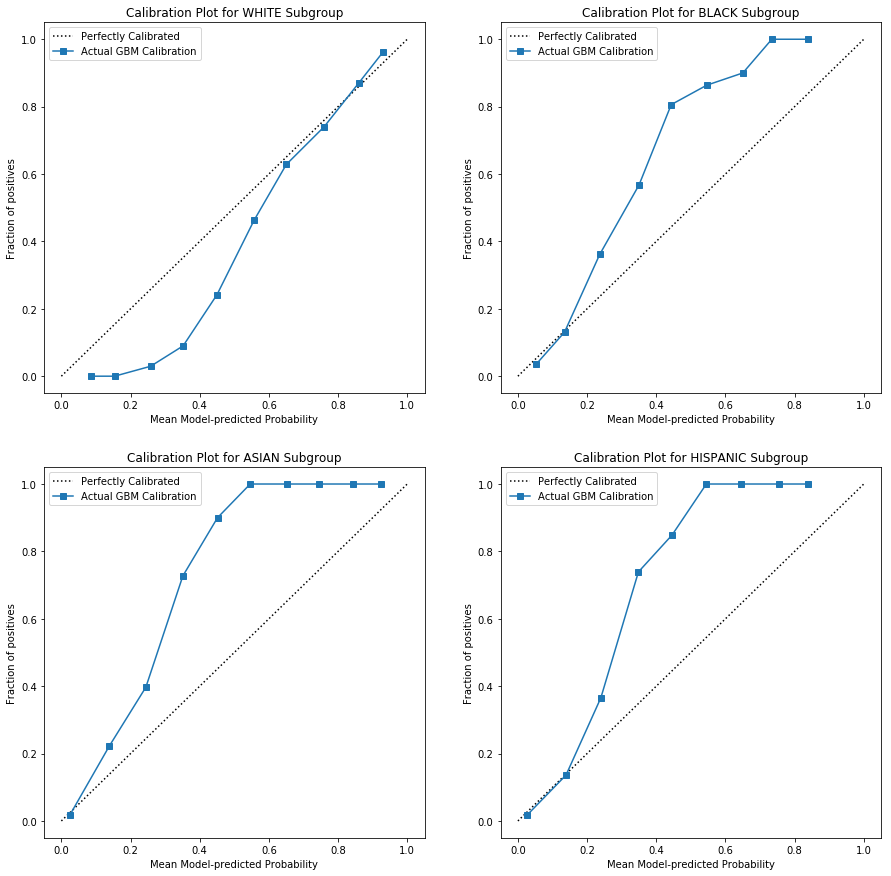

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, t in enumerate(treatments):
    x = i // 2
    y = i % 2
    
    axs[x][y].plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    
    T = df_to_T(df, t)
    fraction_of_positives, mean_predicted_value = calibration_curve(T, all_clfs[t].predict_proba(X)[:, 1], n_bins=10)
    axs[x][y].plot(mean_predicted_value, fraction_of_positives, "s-", label="Actual GBM Calibration")

    axs[x][y].set_ylabel("Fraction of positives")
    axs[x][y].set_ylim([-0.05, 1.05])
    axs[x][y].set_xlabel("Mean Model-predicted Probability")
    axs[x][y].legend(loc="upper left")
    axs[x][y].set_title('Calibration Plot for {} Subgroup'.format(t))

### Checking for Common Support

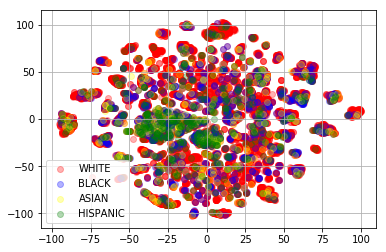

In [16]:
# using t-SNE approach from class
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_patients = len(X)

# project the covariates into a 2-dimensional representation that can be plotted
plot_X = X[:num_patients]
reshaped_X = TSNE(n_components=2).fit_transform(plot_X)

# now plot the projected covariates colored by treatment
colors=['red', 'blue', 'yellow', 'green']
fig, ax = plt.subplots()

for i, t in enumerate(treatments):
    T = df_to_T(df, t)[:num_patients]
    treatment = (T == 1)
    treated_X = reshaped_X[treatment]
    ax.scatter(treated_X[:,0], treated_X[:,1], c=colors[i], label=t, alpha=0.3)

ax.legend()
ax.grid(True)

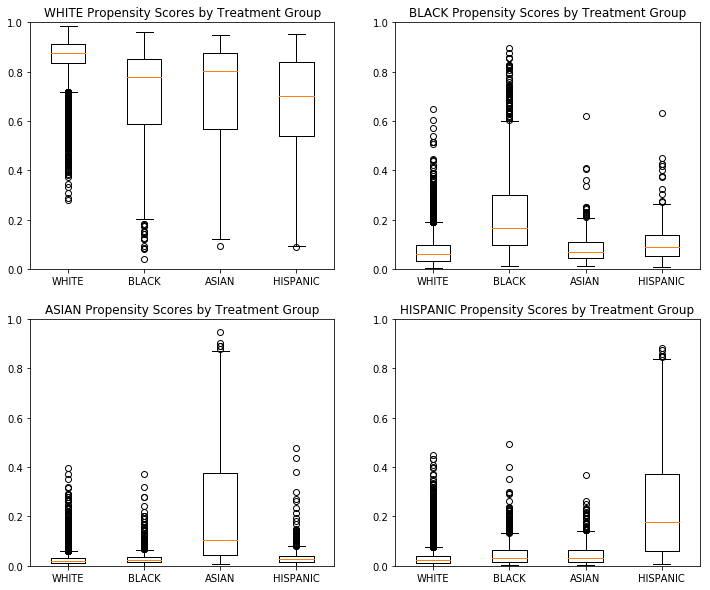

In [17]:
# using box-plot approach from paper
# for each treatment, plot the box plot of the probabilities of patients from each treated group receiving that 
# treatment and check for sufficient overlap among the 4 treatments
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for index, t in enumerate(treatments):
    data = []
    
    for subpopulation in treatments:
        T = df_to_T(df, subpopulation)
        probs = all_clfs[t].predict_proba(X[T == 1])[:, 1]
        data.append(probs)
    
    i = index // 2
    j = index % 2
    
    axs[i][j].set_ylim([0, 1])
    bp = axs[i][j].boxplot(data, notch=0, sym='o', vert=1, whis=1.5)
    axs[i][j].set_title('{} Propensity Scores by Treatment Group'.format(t))
    axs[i][j].set_xticklabels(treatments)

### Checking for Balance

In [20]:
# compute unweighted mean and standard deviation of each covariate for the pooled sample across all treatments
population_covariate_means = np.array(X.mean(axis=0))
population_covariate_stds = np.array(X.std(axis=0))
    
for t in treatments:
    T = df_to_T(df, t)
    X_treated = X[T == 1]
    prop_weights = all_prop_weights[t]
    
    # compare the subpopulation that got this treatment before and after weighting to the unweighted full population
    covariates = np.array(X_treated)
    weights = prop_weights.reshape((len(prop_weights), 1))
    weighted_covariates = np.multiply(covariates, weights)
    
    unweighted_covariate_means = np.array(covariates.mean(axis=0))
    weighted_covariate_means = np.array(weighted_covariates.mean(axis=0))
    
    # for this balance check, we use the population standard bias metric
    PSB_before = np.divide(np.abs(unweighted_covariate_means - population_covariate_means), population_covariate_stds)
    PSB_after = np.divide(np.abs(weighted_covariate_means - population_covariate_means), population_covariate_stds)
    
    bad_covariates_before = []
    bad_covariates_after = []
    for i in range(len(PSB_before)):
        if PSB_before[i] > 0.2:
            bad_covariates_before.append((i, PSB_before[i]))
        if PSB_after[i] > 0.2:
            bad_covariates_after.append((i, PSB_after[i]))
            
    print("Covariates for {} with Standad Bias > 0.2 Before Weighting: {}".format(t, bad_covariates_before))
    print("Covariates for {} with Standad Bias > 0.2 After Weighting: {}".format(t, bad_covariates_after))
    
    # now compute the effective sample size after weighting
    ESS = np.square(np.sum(prop_weights)) / np.sum(np.square(prop_weights))
    print("Effective Sample Size for {} After Weighting: {}".format(t, ESS))
    print("Ratio of ESS to Actual Sample Size for {}: {}".format(t, ESS / len(X_treated)))
    print("----------------------------------------")

Covariates for WHITE with Standad Bias > 0.2 Before Weighting: []
Covariates for WHITE with Standad Bias > 0.2 After Weighting: []
Effective Sample Size for WHITE After Weighting: 8295.837616228671
Ratio of ESS to Actual Sample Size for WHITE: 0.9802478572880386
----------------------------------------
Covariates for BLACK with Standad Bias > 0.2 Before Weighting: [(0, 0.25168893870085873), (99, 0.21252058417578487), (100, 0.27184582141366126)]
Covariates for BLACK with Standad Bias > 0.2 After Weighting: [(101, 0.2761269407738166), (102, 0.22042197453515402)]
Effective Sample Size for BLACK After Weighting: 517.7208149083606
Ratio of ESS to Actual Sample Size for BLACK: 0.5554944365969534
----------------------------------------
Covariates for ASIAN with Standad Bias > 0.2 Before Weighting: [(69, 0.2599222772827024), (99, 0.22564042496619882), (100, 0.3863691564320665), (101, 0.26101228319403813)]
Covariates for ASIAN with Standad Bias > 0.2 After Weighting: [(101, 0.5152770788889232)

### Ignorability Analysis

In [21]:
def compute_ate_high(t1, t2, eps):
    return (all_means[t1] / (1 - eps)) - (all_means[t2] / (1 + eps))

def compute_ate_low(t1, t2, eps):
    return compute_ate_high(t1, t2, -1 * eps)

def print_ate_bounds(t1, t2, eps):
    print("Bounds for ATE {} - {} with epsilon = {}: [{}, {}]".format(t1, t2, eps, compute_ate_low(t1, t2, eps), 
                                                                      compute_ate_high(t1, t2, eps)))

In [22]:
for i in range(len(treatments)):
    for j in range(i+1, len(treatments)):
        for eps in [0.1]:
            print_ate_bounds(treatments[i], treatments[j], eps)

Bounds for ATE WHITE - BLACK with epsilon = 0.1: [86.9129326497514, 152.67715991850767]
Bounds for ATE WHITE - ASIAN with epsilon = 0.1: [156.92147242270494, 209.95687427819695]
Bounds for ATE WHITE - HISPANIC with epsilon = 0.1: [151.2601460069394, 205.32487993802513]
Bounds for ATE BLACK - ASIAN with epsilon = 0.1: [49.10593076698838, 78.18232336565444]
Bounds for ATE BLACK - HISPANIC with epsilon = 0.1: [43.44460435122284, 73.55032902548264]
Bounds for ATE ASIAN - HISPANIC with epsilon = 0.1: [-13.83511000846643, 3.5417892525290853]


### Evaluating ATE Significance by Constructing Bootstrapped Confidence Intervals

### NOTE: This part can take a long time to run, Shreyan can handle this part

In [23]:
# function to efficiently compute all pairwise ATEs
def compute_all_pairwise_ates(df, treatments):    
    X = df_to_X(df)
    Y = df_to_Y(df)

    # compute unweighted mean and standard deviation of each covariate for the pooled sample across all treatments
    population_covariate_means = np.array(X.mean(axis=0))
    population_covariate_stds = np.array(X.std(axis=0))

    all_means = {}

    for t in treatments:
        # compute the weighted mean outcome for this treated subpopulation using propensity scores to weight patients
        T = df_to_T(df, t)
        clf = GradBoost(n_estimators=500).fit(X, T)

        treated = (T == 1)
        X_treated = X[treated]
        prop_weights = (len(X_treated) / len(X)) * np.reciprocal(clf.predict_proba(X_treated)[:,1])
        reciprocal = len(X_treated) # np.sum(prop_weights)
        weighted_mean = sum(np.multiply(Y[treated], prop_weights)) / reciprocal

        all_means[t] = weighted_mean
            
    return all_means

In [24]:
# function that bootstraps dataset and calculates weighted means to construct confidence intervals
def compute_bootstrapped_weighted_means(treatments, old_means, sample_rate, num_trials):
    bootsrap_errors = {}
    for key in all_means:
        bootsrap_errors[key] = []

    for _ in range(num_trials):
        # create a bootstrapped sample 
        bootstrapped_df = df.sample(n = int(sample_rate * len(df)), replace=True)

        # compute the weighted means for this new bootstrapped sample
        new_means = compute_all_pairwise_ates(bootstrapped_df, treatments)
        
        for t in new_means:
            bootsrap_errors[t].append(new_means[t] - old_means[t])
            
    for t in bootsrap_errors:
        bootsrap_errors[t].sort()
        print(bootsrap_errors[t])
        i1 = int(0.975 * num_trials)
        i2 = int(0.025 * num_trials)
        print('95% Confidence Interval for {}: [{}, {}]'.format(t, old_means[t] - bootsrap_errors[t][i1],
                                                 old_means[t] - bootsrap_errors[t][i2]))

In [25]:
num_bootstrap_trials = 5 # use 50 for actual data
bootsrap_sampling_rate = 1

t1 = time.time()
compute_bootstrapped_weighted_means(treatments, all_means, bootsrap_sampling_rate, num_bootstrap_trials)
t2 = time.time()

[-52.74917496834925, -28.783289641952365, -27.078725792719098, -19.32958638330848, -6.411905236227881]
95% Confidence Interval for WHITE: [228.47691563704373, 274.8141853691651]
[-58.17576657616801, -57.951378073420095, -4.589070777331301, 31.39694409250832, 46.86761905019925]
95% Confidence Interval for BLACK: [56.60029552932835, 161.64368115569562]
[-20.21844625161205, -18.779113835273304, -13.717178346977338, -7.299826717807626, 44.76418740254957]
95% Confidence Interval for ASIAN: [-4.30395861868017, 60.67867503548145]
[-25.824934881126886, -20.233595630945686, -12.518190214111137, -3.393567372572008, 42.59626235080556]
95% Confidence Interval for HISPANIC: [2.959160207252822, 71.38035743918527]


In [56]:
print(t2 - t1)

176.47981309890747


Takes 3 minutes to run 5 bootstrapped samples, so 50 should be reasonable